# Image Generation using Autoencoder: MNIST
- **Images**: Handwritten digits **(28x28, grayscale)**.
- **Classes**: 10 digit classes (0-9), but for Autoencoder we **ignore labels**.
- **Shape**: `(batch_size, 1, 28, 28)` ‚Üí 1 grayscale channel.
  
![MNIST image](https://i.imgur.com/TQlKspY.png)


## 1Ô∏è‚É£ Dataset Class

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

# Define transformations (convert to tensor)
transform = transforms.Compose([transforms.ToTensor(),  # Convert to tensor
])

# Load MNIST dataset
train_dataset = MNIST(root="./datasets", train=True, transform=transform, download=True)
test_dataset = MNIST(root="./datasets", train=False, transform=transform, download=True)

# Create DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Check dataset size
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 60000
Test samples: 10000


### Let's display some images

In [16]:
batch = next(iter(train_loader))[0]
batch

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

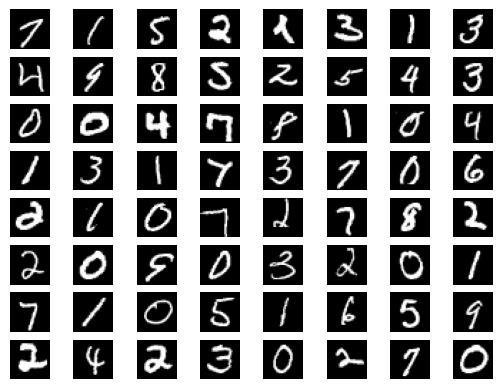

In [17]:
import matplotlib.pyplot as plt
for i in range(batch.shape[0]):
  plt.subplot(8,8,i+1)
  plt.imshow(batch[i,0,:,:], cmap = "gray")
  plt.axis("off")

## 2Ô∏è‚É£ Model Class

# **üìå Autoencoder Model**
An **Autoencoder** is a type of neural network that learns to **compress (encode) and reconstruct (decode) input data**.

## **üîπ Model Structure**
1Ô∏è‚É£ **Encoder**
   - **Conv2D Layers** ‚Üí Extract important features.
   - **Fully Connected Layer** ‚Üí Reduce to a compressed **encoding vector**.
   - Output: **Low-dimensional representation** of the input.

2Ô∏è‚É£ **Decoder**
   - **Fully Connected Layer** ‚Üí Expands compressed representation.
   - **Transpose Convolution Layers** ‚Üí Reconstructs the input.
   - Output: **Reconstructed image** (same shape as input).

![image.png](https://i.imgur.com/SzuIOLi.png)
---
## **üìå Expected Input & Output Shapes**
- **Input:** `(batch_size, 1, 28, 28)`  
- **Encoded Representation:** `(batch_size, encoding_dim)`  
- **Decoded Output:** `(batch_size, 1, 28, 28)`

In [18]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, encoding_dim = 128):
        super(Autoencoder, self).__init__()

        # --- Encoder ---
        # Input: (batch_size, 1, 28, 28)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # -> (batch_size, 16, 14, 14)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # -> (batch_size, 32, 7, 7)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Flatten(),                                         # -> (batch_size, 32 * 7 * 7) = 1568
            nn.Linear(32 * 7 * 7, encoding_dim),                   # -> (batch_size, encoding_dim)
            nn.BatchNorm1d(encoding_dim),
            nn.Tanh(),
            # ÂΩì‰Ω†ÁöÑËæìÂÖ•ÂõæÂÉèÂÉèÁ¥†Ë¢´ÂΩí‰∏ÄÂåñÂà∞ [0, 1] ËåÉÂõ¥Êó∂ÔºàËøôÊòØ MNIST Êï∞ÊçÆÈõÜÂ∏∏Áî®ÂÅöÊ≥ïÔºåÈÄöËøá transforms.ToTensor() ÂÆûÁé∞ÔºâÔºåÊ®°ÂûãÁöÑ‰∏≠Èó¥ÁâπÂæÅÂÄºÂèØËÉΩ‰ºöÂèòÂæó‰ªªÊÑèÂ§ßÊàñÂ∞è„ÄÇ
            # ‰ΩøÁî® Tanh ÊøÄÊ¥ªÂáΩÊï∞ÂèØ‰ª•Â∞ÜËæìÂá∫ÈôêÂà∂Âú® [-1, 1] ËåÉÂõ¥ÂÜÖÔºåËøôÊúâÂä©‰∫éÁ®≥ÂÆöËÆ≠ÁªÉËøáÁ®ã„ÄÇ
            # ËøôÂØπ‰∫éËá™ÁºñÁ†ÅÂô®Êù•ËØ¥ÊòØÊúâÁõäÁöÑÔºåÂõ†‰∏∫ÂÆÉÂèØ‰ª•Èò≤Ê≠¢Ê¢ØÂ∫¶ÁàÜÁÇ∏ÊàñÊ∂àÂ§±ÈóÆÈ¢òÔºåÂ∞§ÂÖ∂ÊòØÂú®Ê∑±Â±ÇÁΩëÁªú‰∏≠„ÄÇ
            # Ëøô‰πüÊúâÂä©‰∫éÂú®Ëß£Á†ÅÂô®‰∏≠‰ΩøÁî® Sigmoid ÊøÄÊ¥ªÂáΩÊï∞
            # Âõ†‰∏∫ Sigmoid ÁöÑËæìÂá∫ËåÉÂõ¥ÊòØ [0, 1]ÔºåËÄå Tanh ÁöÑËæìÂá∫ËåÉÂõ¥ÊòØ [-1, 1]ÔºåÊâÄ‰ª•Âú®ÁºñÁ†ÅÂô®ÂíåËß£Á†ÅÂô®‰πãÈó¥‰ΩøÁî® Tanh ÂèØ‰ª•Êõ¥Â•ΩÂú∞ÈÄÇÂ∫î Sigmoid ÁöÑËæìÂá∫ËåÉÂõ¥„ÄÇ

        )

        # --- Decoder ---
        # Input: (batch_size, encoding_dim)
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32 * 7 * 7),                  # -> (batch_size, 1568)
            nn.BatchNorm1d(32 * 7 * 7),
            nn.LeakyReLU(),
            nn.Unflatten(1, (32, 7, 7)),                          # -> (batch_size, 32, 7, 7)
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (batch_size, 16, 14, 14)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (batch_size, 1, 28, 28)
            nn.Sigmoid()                                          # -> Output values between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## 3Ô∏è‚É£ Training and Validation Loops

We will train a model and show images instantly without a validation loop.

1Ô∏è‚É£ **Forward Pass** ‚Üí Encode & Decode the image.  
2Ô∏è‚É£ **Compute Loss** ‚Üí Measure the difference between input & reconstructed output.  
3Ô∏è‚É£ **Backward Pass** ‚Üí Adjust model parameters using backpropagation.  


## 4Ô∏è‚É£ Running Training

Unlike classification, Autoencoders use **MSE Loss** to compare the reconstructed image with the input.


In [10]:
from tqdm import tqdm    # Shows progress bar
import torch.backends.mps  # For Apple Silicon GPU support

# Check if MPS (Metal Performance Shaders) is available for Apple Silicon GPU acceleration
# MPS is a framework that allows PyTorch to utilize the GPU on Apple Silicon devices.
# If MPS is not available, we will fall back to CPU.
# This is particularly useful for users with MacBooks or Macs with M1/M2 chips.
# Note: MPS support is available in PyTorch 1.12 and later versions.
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for Apple Silicon GPU acceleration.")
else:
    device = torch.device("cpu")
    print("MPS device not found, falling back to CPU.")

# Model Initialization
encoding_dim = 16
model = Autoencoder(encoding_dim=encoding_dim).to(device)

# Print model structure
print("Model structure:")
print(model)

# Loss function
criterion = nn.MSELoss()

# Optimizer
# We use the Adam optimizer, a popular and effective choice for many problems.
# It adjusts the learning rate for each parameter.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # lr = learning rate

# Training Loop
num_epochs = 50 # Increase from 10
patience = 5    # Increase patience slightly for longer training

outputs = []
losses = []

print("üöÄ Starting training...")

for epoch in range(num_epochs):
    # 1. Âú®ÊØè‰∏™ epoch ÂºÄÂßãÊó∂ÔºåÂàùÂßãÂåñ‰∏Ä‰∏™Á¥ØÂä†Âô®
    running_loss = 0.0

    # ÈÅçÂéÜÊâÄÊúâÊâπÊ¨°
    for images, _ in tqdm(train_loader):
        images = images.to(device)
        reconstructed = model(images)
        loss = criterion(reconstructed, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 2. Á¥ØÂä†ÊØè‰∏™ÊâπÊ¨°ÁöÑÊçüÂ§±ÂÄº
        # loss.item() ÊòØÂΩìÂâçÊâπÊ¨°ÁöÑÂπ≥ÂùáÊçüÂ§±
        running_loss += loss.item()

    # 3. Âú® epoch ÁªìÊùüÂêéÔºåËÆ°ÁÆóÊï¥‰∏™ epoch ÁöÑÂπ≥ÂùáÊçüÂ§±
    epoch_loss = running_loss / len(train_loader) # ÊÄªÊçüÂ§±Èô§‰ª•ÊÄªÊâπÊ¨°Êï∞

    # 4. ÊâìÂç∞Âπ≥ÂùáÊçüÂ§±
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}')
    losses.append(epoch_loss) # ‰øùÂ≠òÂπ≥ÂùáÊçüÂ§±‰ª•‰æøÂêéÁª≠ÁªòÂõæ

    # (ÂèØÈÄâ) ‰ªçÁÑ∂ÂèØ‰ª•‰øùÂ≠òÊúÄÂêé‰∏Ä‰∏™ÊâπÊ¨°ÁöÑÂõæÂÉèÁî®‰∫éÂèØËßÜÂåñ
    outputs.append((epoch, images.cpu(), reconstructed.cpu()))

print("üéâ Training finished! üéâ")

Using MPS device for Apple Silicon GPU acceleration.
Model structure:
Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1568, out_features=16, bias=True)
    (8): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=1568, bias=True)
    (1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Unflatten(dim=1, unflattened_size=(32, 7, 7))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:10<00:00, 87.38it/s] 


Epoch [1/50], Average Loss: 0.0400


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 114.82it/s]


Epoch [2/50], Average Loss: 0.0164


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:07<00:00, 118.05it/s]


Epoch [3/50], Average Loss: 0.0146


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 106.88it/s]


Epoch [4/50], Average Loss: 0.0138


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:07<00:00, 122.06it/s]


Epoch [5/50], Average Loss: 0.0132


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 115.35it/s]


Epoch [6/50], Average Loss: 0.0129


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 110.13it/s]


Epoch [7/50], Average Loss: 0.0126


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 106.78it/s]


Epoch [8/50], Average Loss: 0.0124


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 114.17it/s]


Epoch [9/50], Average Loss: 0.0123


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 106.76it/s]


Epoch [10/50], Average Loss: 0.0121


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 111.69it/s]


Epoch [11/50], Average Loss: 0.0120


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 114.82it/s]


Epoch [12/50], Average Loss: 0.0119


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 115.29it/s]


Epoch [13/50], Average Loss: 0.0119


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 116.86it/s]


Epoch [14/50], Average Loss: 0.0118


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:07<00:00, 118.85it/s]


Epoch [15/50], Average Loss: 0.0117


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 116.41it/s]


Epoch [16/50], Average Loss: 0.0117


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:07<00:00, 118.91it/s]


Epoch [17/50], Average Loss: 0.0116


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:07<00:00, 117.56it/s]


Epoch [18/50], Average Loss: 0.0115


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:07<00:00, 121.89it/s]


Epoch [19/50], Average Loss: 0.0115


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 114.84it/s]


Epoch [20/50], Average Loss: 0.0115


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 106.02it/s]


Epoch [21/50], Average Loss: 0.0114


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:07<00:00, 119.13it/s]


Epoch [22/50], Average Loss: 0.0114


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:07<00:00, 121.53it/s]


Epoch [23/50], Average Loss: 0.0114


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:07<00:00, 117.86it/s]


Epoch [24/50], Average Loss: 0.0113


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:07<00:00, 127.31it/s]


Epoch [25/50], Average Loss: 0.0113


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:07<00:00, 125.34it/s]


Epoch [26/50], Average Loss: 0.0113


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:07<00:00, 122.02it/s]


Epoch [27/50], Average Loss: 0.0112


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:07<00:00, 118.92it/s]


Epoch [28/50], Average Loss: 0.0112


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:07<00:00, 118.52it/s]


Epoch [29/50], Average Loss: 0.0112


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:09<00:00, 102.07it/s]


Epoch [30/50], Average Loss: 0.0112


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 107.05it/s]


Epoch [31/50], Average Loss: 0.0111


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 108.89it/s]


Epoch [32/50], Average Loss: 0.0111


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 111.40it/s]


Epoch [33/50], Average Loss: 0.0111


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 109.35it/s]


Epoch [34/50], Average Loss: 0.0110


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 113.37it/s]


Epoch [35/50], Average Loss: 0.0110


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 110.38it/s]


Epoch [36/50], Average Loss: 0.0110


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 111.99it/s]


Epoch [37/50], Average Loss: 0.0110


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 115.69it/s]


Epoch [38/50], Average Loss: 0.0110


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 105.61it/s]


Epoch [39/50], Average Loss: 0.0109


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 113.19it/s]


Epoch [40/50], Average Loss: 0.0109


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 111.15it/s]


Epoch [41/50], Average Loss: 0.0109


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 114.02it/s]


Epoch [42/50], Average Loss: 0.0109


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 114.80it/s]


Epoch [43/50], Average Loss: 0.0109


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 108.62it/s]


Epoch [44/50], Average Loss: 0.0108


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 110.84it/s]


Epoch [45/50], Average Loss: 0.0108


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:08<00:00, 106.84it/s]


Epoch [46/50], Average Loss: 0.0109


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:07<00:00, 121.30it/s]


Epoch [47/50], Average Loss: 0.0108


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:07<00:00, 127.11it/s]


Epoch [48/50], Average Loss: 0.0108


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:07<00:00, 128.89it/s]


Epoch [49/50], Average Loss: 0.0108


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 938/938 [00:07<00:00, 128.57it/s]

Epoch [50/50], Average Loss: 0.0108
üéâ Training finished! üéâ


### Plot loss and some predictions

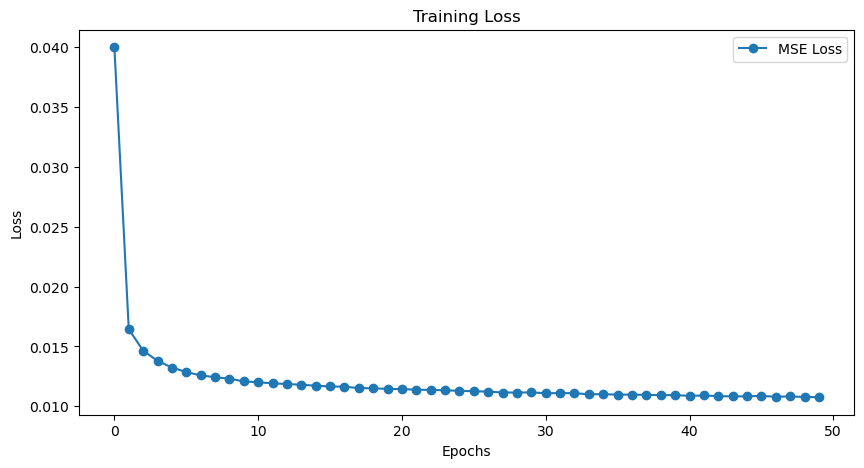

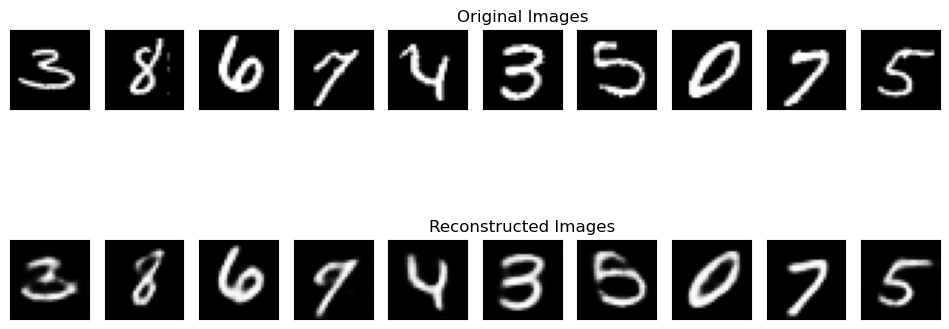

In [19]:
# Plot the loss
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses,label="MSE Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Visualize the last batch of original and reconstructed images
original_images = outputs[-1][1].detach().numpy()
reconstructed_images = outputs[-1][2].detach().numpy()

# Number of images to display
n = 10

plt.figure(figsize=(12, 5))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n // 2:
        ax.set_title("Original Images")


    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n // 2:
        ax.set_title("Reconstructed Images")
plt.show()

Let's generate some images:

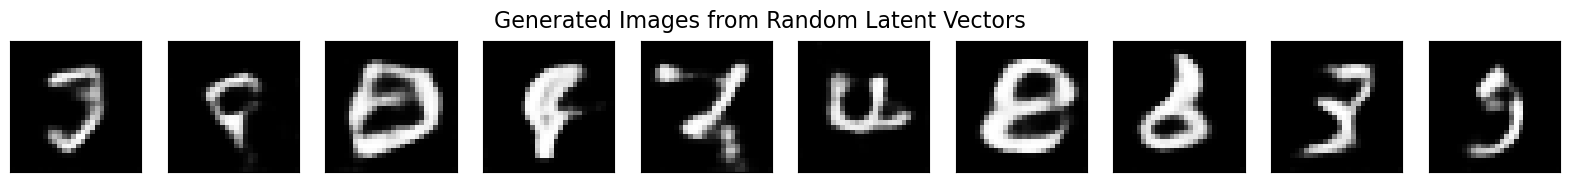

In [12]:
# Generate images by feeding random vectors to the decoder
num_generated_images = 10

with torch.no_grad(): # We don't need to compute gradients for this
    # Create random latent vectors
    random_vectors = torch.randn(num_generated_images, encoding_dim).to(device)

    # Decode them to create new images
    generated_images = model.decoder(random_vectors).cpu()

# Display the generated images
plt.figure(figsize=(20, 2))
for i in range(num_generated_images):
    ax = plt.subplot(1, num_generated_images, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.suptitle("Generated Images from Random Latent Vectors", fontsize=16)
plt.show()

Close Enough :)

In [14]:
encoder_model = model.encoder
encoder_model.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1568, out_features=16, bias=True)
  (8): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Tanh()
)

In [20]:
import numpy as np

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for Apple Silicon GPU acceleration.")
else:
    device = torch.device("cpu")
    print("MPS device not found, falling back to CPU.")

encoder_model.to(device)

latent_vectors_list = []
true_labels_list = []

# ÂØπÊµãËØïÈõÜËøõË°åËø≠‰ª£ÔºåËé∑ÂèñÊâÄÊúâÊΩúÂú®ÂêëÈáèÂíåÂØπÂ∫îÁöÑÊ†áÁ≠æ
with torch.no_grad(): # Âú®Êé®ÁêÜÊó∂‰∏çÈúÄË¶ÅËÆ°ÁÆóÊ¢ØÂ∫¶
    for images, labels in test_dataloader:
        images = images.to(device)
        # Â¶ÇÊûú‰Ω†ÁöÑÁºñÁ†ÅÂô®ÊúüÊúõÂ±ïÂπ≥ÁöÑËæìÂÖ•ÔºåËØ∑Âú®ËøôÈáåÂ±ïÂπ≥
        # ‰æãÂ¶ÇÔºöimages = images.view(images.size(0), -1)

        latent = encoder_model(images)
        latent_vectors_list.append(latent.cpu().numpy())
        true_labels_list.append(labels.cpu().numpy())

latent_vectors = np.concatenate(latent_vectors_list, axis=0)
true_labels = np.concatenate(true_labels_list, axis=0)

print(f"ÊΩúÂú®ÂêëÈáèÁöÑÂΩ¢Áä∂: {latent_vectors.shape}")
print(f"Ê†áÁ≠æÁöÑÂΩ¢Áä∂: {true_labels.shape}")

Using MPS device for Apple Silicon GPU acceleration.
ÊΩúÂú®ÂêëÈáèÁöÑÂΩ¢Áä∂: (10000, 16)
Ê†áÁ≠æÁöÑÂΩ¢Áä∂: (10000,)


ÂºÄÂßãt-SNEÈôçÁª¥...
t-SNEÈôçÁª¥ÂÆåÊàê„ÄÇ
ÈôçÁª¥ÂêéÁöÑÂΩ¢Áä∂: (10000, 2)


/var/folders/rh/2t3sy5bx13nctf2n07gkzskh0000gn/T/ipykernel_52841/2441294119.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels)) # ‰ΩøÁî®tab10È¢úËâ≤Êò†Â∞Ñ


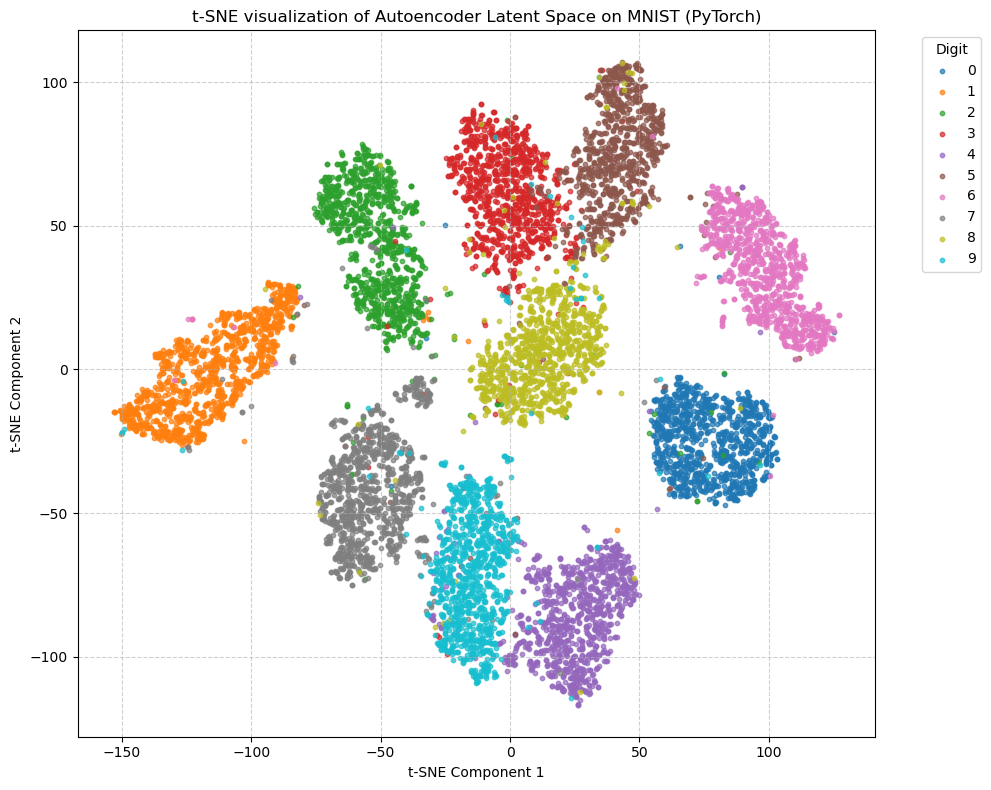

In [ ]:
print("ÂºÄÂßãt-SNEÈôçÁª¥...")
# ÂáèÂ∞ëÊï∞ÊçÆÈáè‰ª•Âä†Âø´t-SNEÔºåÊàñËÄÖ‰ΩøÁî®ÂÆåÊï¥Êï∞ÊçÆÈõÜÂ¶ÇÊûúÂÜÖÂ≠òÂÖÅËÆ∏‰∏îËÆ°ÁÆóÊó∂Èó¥ÂèØÊé•Âèó
# num_samples_for_tsne = 5000
# if latent_vectors.shape[0] > num_samples_for_tsne:
#     # ÈöèÊú∫ÈÄâÊã©‰∏ÄÈÉ®ÂàÜÊ†∑Êú¨
#     indices = np.random.choice(latent_vectors.shape[0], num_samples_for_tsne, replace=False)
#     tsne_latent_vectors = latent_vectors[indices]
#     tsne_true_labels = true_labels[indices]
# else:
tsne_latent_vectors = latent_vectors
tsne_true_labels = true_labels

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=3000)
latent_2d = tsne.fit_transform(tsne_latent_vectors)
print("t-SNEÈôçÁª¥ÂÆåÊàê„ÄÇ")
print(f"ÈôçÁª¥ÂêéÁöÑÂΩ¢Áä∂: {latent_2d.shape}")

# ÂèØËßÜÂåñÁªìÊûú
plt.figure(figsize=(10, 8))

unique_labels = np.unique(tsne_true_labels)
colors = plt.cm.get_cmap('tab10', len(unique_labels)) # ‰ΩøÁî®tab10È¢úËâ≤Êò†Â∞Ñ

for i, label in enumerate(unique_labels):
    indices = tsne_true_labels == label
    plt.scatter(latent_2d[indices, 0], latent_2d[indices, 1],
                color=colors(i),
                label=str(label),
                alpha=0.7,
                s=10)

plt.title('t-SNE visualization of Autoencoder Latent Space on MNIST (PyTorch)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## **üîπ Exercise: Effect of Encoding Dimension on Reconstruction**
The **encoding dimension** controls how much information is compressed in the latent space.

### **üìù Task**
- Try running the model with **different `encoding_dim` values** (e.g., `1, 2, 128, 256`).
- Observe how the quality of the **reconstructed images** changes.

### Our Solution:

When we changerd the `encoding_dim` to 128, we can see that the model is able to reconstruct the images with a lower loss compared to when it was set to 16. This indicates that a higher dimensional latent space allows the model to capture more information about the input images, leading to better reconstructions.

### Contributed by: Mohamed Eltayeb

## New discovery about the importance of batch's normalizing

Âú®Á¨¨‰∏ÄÊ¨°‰∏≠ÔºåÊàëÂØπ‰∫ébatchÊ≤°ÊúâËøõË°ånormalizeÁöÑÊìç‰ΩúÔºåÊúÄÂêéÂæóÂà∞ÁöÑlossËøòÁÆóÊØîËæÉÂ•ΩÔºå‰ΩÜÊòØÁî±‰∫éÊàëÂÖ∂ÂÆûËøõË°å‰∫Ü50‰∏™epochÔºåÊâÄ‰ª•ÂÖ∂ÂÆûËøôÊòØÊ®°ÂûãËÆ≠ÁªÉcostyÁöÑÂäüÂä≥ÔºàËã¶Âä≥Ôºâ„ÄÇ

‰ΩÜÊòØÈóÆÈ¢òÂú®‰∫éÔºå**ÁîüÊàêÁöÑÂõæÁâáÊòØ‰∏ÄÂù®üí©ÔºÅ**
ÈùûÂ∏∏ÁöÑÊ∑∑Ê≤åÔºåÂæàÈöæÁúãÂá∫ÊòØ‰ªÄ‰πàÊï∞Â≠óÔºåËÄåÊúÄÈáçË¶ÅÁöÑÈóÆÈ¢òÂú®‰∫éÈùûÂ∏∏Èªë‰∏çÊ∫úÁßãÔºåÁôΩÁöÑÈÉ®ÂàÜÈùûÂ∏∏Â∞ë„ÄÇ

Âú®Â¢ûÂä†‰∫ÜÊñ∞ÁöÑbatch  normalize‰πãÂêéÔºåÊ®°ÂûãÁöÑÊïàÊûúÂ§ßÂ§ßÊèêÂçá‰∫ÜÔºåÊúÄ‰∏ªË¶ÅÊèêÂçáÁöÑÊòØÔºöÊàë‰ª¨ÂèØ‰ª•ÁúãÂá∫Êù•ÁôΩËâ≤ÁöÑÈÉ®ÂàÜ‰∫ÜÔºå‰ª•ÂèäÂèØ‰ª•ÁúãÂá∫‰∏Ä‰∫õ‰∫õÊï∞Â≠óÁöÑÊ®°Ê†∑ÔºåËôΩÁÑ∂ÂíåÊàë‰ª¨Áé∞ÂÆûÁîüÊ¥ª‰∏≠ÁöÑÊï∞Â≠ó‰∏çÊòØÂæàÁõ∏ÂÉèÔºå‰ΩÜÊòØÂÖ∂ÂÆûÊòØÊàë‰ª¨ÁöÑÊ®°ÂûãÊé¢Á¥¢Âá∫Êù•ÁöÑÂØπ‰∫é‚Äú‰∫∫Á±ªÁöÑÊï∞Â≠óÂ∫îËØ•Èïø‰ªÄ‰πàÊ†∑‚ÄùÁöÑ‰∏ÄÁßçÊäΩË±°ËßÇÂØü‰∏éÁõ¥Ëßâ„ÄÇ

**batch  normalizingÁöÑÂ•ΩÂ§ÑÔºö**

* Âä†ÈÄüËÆ≠ÁªÉÊî∂ÊïõÔºö ÊâπÈáèÂΩí‰∏ÄÂåñÊúâÂä©‰∫éÁºìËß£‚ÄúÂÜÖÈÉ®ÂçèÂèòÈáèÂÅèÁßª‚ÄùÈóÆÈ¢òÔºåÂç≥‰ΩøÂæóÊØè‰∏ÄÂ±ÇÁöÑËæìÂÖ•ÂàÜÂ∏É‰øùÊåÅÁ®≥ÂÆö„ÄÇËøôÂÖÅËÆ∏Ê®°Âûã‰ΩøÁî®Êõ¥È´òÁöÑÂ≠¶‰π†ÁéáÔºå‰ªéËÄåÊõ¥Âø´Âú∞Êî∂Êïõ„ÄÇ

* ÊèêÈ´òËÆ≠ÁªÉÁ®≥ÂÆöÊÄßÔºö ÈÄöËøáÂ∞ÜÊøÄÊ¥ªÂÄºÂΩí‰∏ÄÂåñÔºåÂÆÉÂèØ‰ª•Èò≤Ê≠¢ÊøÄÊ¥ªÂÄºÂú®ÁΩëÁªúÊ∑±Â±ÇÂèòÂæóËøáÂ§ßÊàñËøáÂ∞èÔºå‰ªéËÄåÁºìËß£Ê¢ØÂ∫¶Ê∂àÂ§±ÊàñÊ¢ØÂ∫¶ÁàÜÁÇ∏ÈóÆÈ¢òÔºå‰ΩøÂæóËÆ≠ÁªÉËøáÁ®ãÊõ¥Âä†Á®≥ÂÆö„ÄÇ

* Ê≠£ÂàôÂåñÊïàÊûúÔºö ÊâπÈáèÂΩí‰∏ÄÂåñÂú®ÊØè‰∏™Â∞èÊâπÊ¨°‰∏äÂºïÂÖ•ÁöÑÂùáÂÄºÂíåÊñπÂ∑Æ‰º∞ËÆ°ÁöÑÂô™Â£∞ÔºåÁ±ª‰ºº‰∫é DropoutÔºåÂèØ‰ª•Ëµ∑Âà∞ËΩªÂæÆÁöÑÊ≠£ÂàôÂåñ‰ΩúÁî®ÔºåÂáèÂ∞ëÊ®°ÂûãÂØπËÆ≠ÁªÉÊï∞ÊçÆÁöÑËøáÊãüÂêàÔºåÊèêÈ´òÊ≥õÂåñËÉΩÂäõ„ÄÇ

* ÂØπÂàùÂßãÂåñ‰∏çÈÇ£‰πàÊïèÊÑüÔºö Ê®°ÂûãÂØπÊùÉÈáçÂàùÂßãÂåñÁöÑÈÄâÊã©‰∏çÂÜçÈÇ£‰πàÊïèÊÑü„ÄÇ

ÊÄª‰πãÔºå**ÊâπÈáèÂΩí‰∏ÄÂåñÂ±Ç**ÔºöÂ§ßÂ§ßÂ¢ûÂº∫‰∫ÜËÆ≠ÁªÉÁöÑ**Á®≥ÂÆöÊÄß**Âíå**Êî∂ÊïõÈÄüÂ∫¶**ÔºåÂπ∂Êèê‰æõ‰∫ÜÈ¢ùÂ§ñÁöÑÊ≠£ÂàôÂåñÊïàÊûú

In [18]:
### ‰∏Ä‰∏™ÂÖ∏ÂûãÁöÑÊ∑±Â∫¶Â≠¶‰π†‰ª£Á†ÅÊ°ÜÊû∂Ôºö

# ÂàùÂßãÂåñÊ®°Âûã„ÄÅÊçüÂ§±ÂáΩÊï∞Âíå‰ºòÂåñÂô®
model = Autoencoder(...)
criterion = nn.MSELoss() # ÊçüÂ§±ÂáΩÊï∞
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam ‰ºòÂåñÂô®

# ËÆ≠ÁªÉÂæ™ÁéØ (for each epoch)
for epoch in range(num_epochs):
    # ÈÅçÂéÜÊØè‰∏™ÊâπÊ¨° (for each batch)
    for batch_idx, data in enumerate(dataloader):
        # 0. Ê∏ÖÈô§‰πãÂâçÁöÑÊ¢ØÂ∫¶ (ÈáçË¶ÅÊ≠•È™§ÔºåÈò≤Ê≠¢Ê¢ØÂ∫¶Á¥ØÁßØ)
        optimizer.zero_grad() # Adam ‰ºòÂåñÂô®ÁöÑ‰∏Ä‰∏™ÊñπÊ≥ï

        # 1. Forward Pass (ÂâçÂêë‰º†Êí≠)
        reconstructed_output = model(data) # ÁºñÁ†ÅÂíåËß£Á†ÅÂõæÂÉè

        # 2. Compute Loss (ËÆ°ÁÆóÊçüÂ§±)
        loss = criterion(reconstructed_output, data) # ÊµãÈáèËæìÂÖ•‰∏éÈáçÂª∫ËæìÂá∫ÁöÑÂ∑ÆÂºÇ

        # 3. Backward Pass (ÂèçÂêë‰º†Êí≠)
        loss.backward() # ËÆ°ÁÆóÊçüÂ§±ÂØπÊ®°ÂûãÂèÇÊï∞ÁöÑÊ¢ØÂ∫¶

        # 4. Optimizer Step (‰ºòÂåñÂô®Êõ¥Êñ∞ÂèÇÊï∞)
        optimizer.step() # Adam ‰ºòÂåñÂô®Ê†πÊçÆËÆ°ÁÆóÂá∫ÁöÑÊ¢ØÂ∫¶Ë∞ÉÊï¥Ê®°ÂûãÂèÇÊï∞
                          # ËøôÊòØ Adam ÂÖ∑‰ΩìÁÆóÊ≥ïÈÄªËæëÂèëÊå•‰ΩúÁî®ÁöÑÂú∞Êñπ
                          # ÂÆÉ‰ºöËÄÉËôëÊ¢ØÂ∫¶ÁöÑÂéÜÂè≤‰ø°ÊÅØÔºàÂä®ÈáèÂíåËá™ÈÄÇÂ∫îÂ≠¶‰π†ÁéáÔºâÊù•Êõ¥Êñ∞ÂèÇÊï∞